In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from deepmeg.convtools import compute_output_shape, conviter

In [2]:
def gaussian_random_walk(n: int, stepsize: float = 1.0) -> np.ndarray:
    """
    Generates a Gaussian random walk for a given number of points using numpy.

    Args:
        n: the number of points in the random walk
        stepsize: the standard deviation of the Gaussian distribution used to generate the random steps (default is 1.0)

    Returns:
        A numpy array of shape (n, 2) representing the x and y coordinates of the random walk.
    """
    # Generate random steps using a Gaussian distribution
    steps = np.random.normal(loc=0, scale=stepsize, size=(n, 2))

    # Compute the coordinates of the random walk by cumulatively summing the steps
    walk = np.cumsum(steps, axis=0)

    return walk.T[0]


def moving_average(data: np.ndarray, kernel_size: int = 20) -> np.ndarray:
    """
    Compute the moving average of a given data array.

    Parameters
    ----------
    data : np.ndarray
        The data array.
    kernel_size : int
        The size of the kernel.

    Returns
    -------
    np.ndarray
        The moving average of the data array.
    """
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(data, kernel, mode='same')


def gen_random_data(
    batch_size,
    n_timepoints,
    out_dim,
    ma1=20,
    ma2=5
):
    data = list()
    labels = list()

    for _ in range(batch_size):
        X = 2*np.random.random((n_timepoints,)) - 1
        # X = gaussian_random_walk(n_timepoints).T[0]
        # Y = np.zeros(out_dim)
        Y = np.zeros(out_dim)
        X = moving_average(X, ma1)
        # start = np.random.randint(0, n_timepoints//4) + 250
        # dist = np.random.randint(n_timepoints//10, n_timepoints//4)
        start = np.random.randint(0, n_timepoints//2)
        dist = np.random.randint(n_timepoints//10, n_timepoints//2)
        stop = start + dist
        X[start:stop] += moving_average(2*np.random.random((stop - start)) - 1, ma2)
        # X[start:stop] = gaussian_random_walk(stop - start, 5).T[0]
        ratio = n_timepoints/out_dim
        Y[int(start/ratio):int(stop/ratio)] = 1
        # Y[start//ratio:stop//ratio] = 0
        data.append(X)
        labels.append(Y)

    return np.array(data), np.array(labels)

def interpolate_sequence(original_sequence: np.ndarray, new_length: int) -> np.ndarray:
    """
    Interpolate a sequence of length 'n' into a sequence of length 'm' (m > n)

    Args:
        original_sequence: A numpy array of shape (n, ) representing the original sequence
        new_length: An integer, the desired length of the interpolated sequence

    Returns:
        A numpy array of shape (m, ) representing the interpolated sequence
    """
    x = np.arange(original_sequence.shape[0])
    f = original_sequence
    x_new = np.linspace(0, x.max(), new_length)
    f_new = np.interp(x_new, x, f)
    return f_new

# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

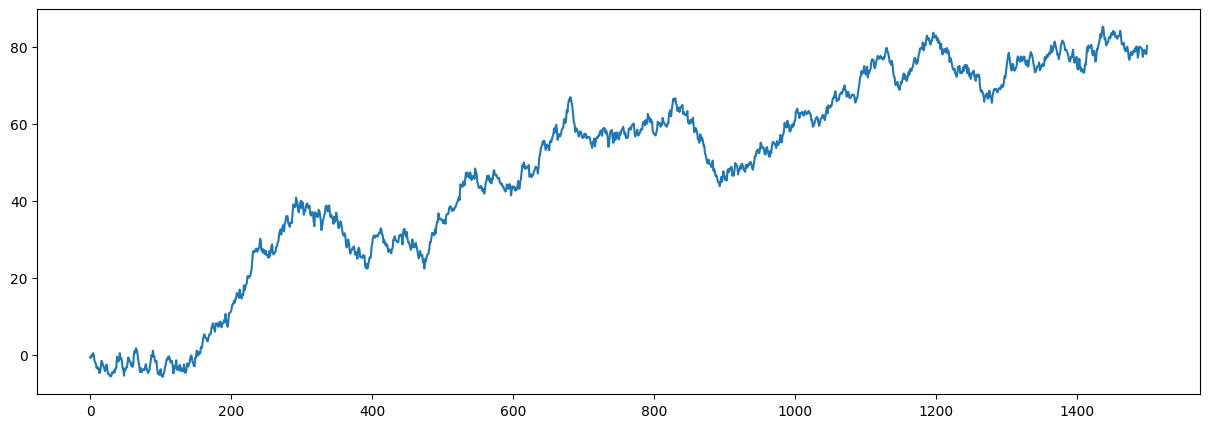

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(gaussian_random_walk(1500))


In [58]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch

from deepmeg.models import BaseModel

class Fourier(nn.Module):
    def __init__(self, n_points, n_components):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.a = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.b = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))

        self.a0 = nn.Parameter(torch.empty(1))


        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.a, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        init.uniform_(self.a0, -0.01, 0.01)

    def forward(self, x):
        out = self.a0/(2*self.n_points)*torch.ones_like(x)
        for n in range(self.n_components):
            out += (x@self.a[:, n])*torch.cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*torch.sin((2*np.pi*x*n)/self.n_points)

        return out


class FourierNet(BaseModel):

    def __init__(self, n_points, n_components=None):
        super().__init__()

        if n_components is None:
            n_components = n_points//2

        self.layer = Fourier(n_points, n_components)
        self.bn = nn.BatchNorm1d(n_points)

    def forward(self, x):
        x = self.bn(x)
        x = self.layer(x)
        return x

from deepmeg.convtools import compute_output_shape, conviter

class AutoCov1D(nn.Module):
    def __init__(self, out_channels, window_size, latent_dim = None, overlap=0, stride=1, padding=0, bias=True):
        super().__init__()
        self.window_size = window_size
        self.overlap = overlap
        self.stride = stride
        self.padding = padding
        # self.weight = nn.Parameter(torch.empty(self.window_size, self.latent_dim, out_channels))
        self.transform = nn.ModuleList([FourierNet(self.window_size) for _ in range(out_channels)])
        self.transform2 = nn.ModuleList([FourierNet(self.window_size) for _ in range(out_channels)])

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        # init.uniform_(self.weight, -0.01, 0.01)
        if self.bias is not None:
            init.uniform_(self.bias, -0.01, 0.01)

    def forward(self, X):
        # inputs shape (N_batch, width) ~ (N_batch, n_times)
        X_part1 = X[:, :-(self.window_size - self.overlap)] # shape: (batches, times)
        X_part2 = X[:, self.window_size - self.overlap:,]

        assert X_part1.shape == X_part2.shape, f'Windowed sequence is corrupted: {X_part1.shape} vs {X_part2.shape}'

        convargs = ((X_part1.shape[1], X_part1.shape[0]), self.window_size, self.padding, self.stride)
        n_windows = compute_output_shape(*convargs)[0]
        out_tensor = torch.zeros(X.shape[0], n_windows, len(self.transform)) # ~ batches x n_windows x out_channels

        # iter over neurons
        for n_neuron in range(len(self.transform)):
            for p, q, k in conviter(*convargs):
                # p shape: n_times, ...
                # q shape: n_windows, 0
                # k shape: window_size, ...
                pad_params = list()

                time_range = p[0]
                window_range = k[0]
                n_window = q[0]

                if window_range.start is not None and abs(window_range.start) < self.window_size:
                    pad_params.append(abs(window_range.start))
                else:
                    pad_params.append(0)
                if window_range.stop is not None and abs(window_range.stop) < self.window_size:
                    pad_params.append(abs(window_range.stop))
                else:
                    pad_params.append(0)

                window1 = X_part1[:, time_range]
                window2 = X_part2[:, time_range]

                if pad_params != [0, 0]:
                    window1 = nn.functional.pad(window1, pad_params)
                    window2 = nn.functional.pad(window2, pad_params)

                # weight = self.weight[window_range, :, n_neuron]

                # proj1 = torch.matmul(window1, weight) # (N batch x time_range) @ (window_range x latent_dim x n_neuron) = (N batch x latent_dim)
                # proj2 = torch.matmul(window2, weight)
                proj1 = self.transform[n_neuron](window1)
                proj2 = self.transform[n_neuron](window2)
                # proj2 = window2
                # proj2 = self.transform2[n_neuron](window2)

                cov = torch.mean(
                    (proj1 - torch.mean(proj1, 1, keepdim=True))*
                    (proj2 - torch.mean(proj2, 1, keepdim=True)),
                    1,
                    keepdim=True
                ) # ~ (N_batch, 1)
                out_tensor[:, n_window, n_neuron] = torch.squeeze(cov, -1) + self.bias[n_neuron] if self.bias is not None else torch.squeeze(cov, -1)

        return out_tensor


In [55]:
import scipy as sp

def gen_random_data_by(
    batch_size,
    n_timepoints,
    out_dim,
    transform
):
    data = list()
    labels = list()

    for _ in range(batch_size):
        X = sp.stats.zscore(gaussian_random_walk(n_timepoints))
        # X = 2*np.random.random((n_timepoints,)) - 1
        Y = np.zeros(out_dim)

        start = np.random.randint(0, n_timepoints - n_timepoints//10)
        # dist = np.random.randint(n_timepoints//10, n_timepoints//2)
        # stop = start + dist
        stop = max(np.random.randint(start, n_timepoints), start + n_timepoints//10)
        X[start:stop] = transform(X[start:stop])
        ratio = n_timepoints/out_dim
        Y[int(start/ratio):int(stop/ratio)] = 1
        data.append(X)
        labels.append(Y)

    return np.array(data), np.array(labels)

In [56]:
x, y = gen_random_data_by(
    1000, 500, 500,
    # lambda x: np.sin(np.pi*x),
    # lambda x: 1.5 + 2.13*x + 0.5*x**2 - 3.1*x**3 + 1.2*x**4
    lambda x: x**5
)
dataset = EpochsDataset((x, y), savepath='../trash')

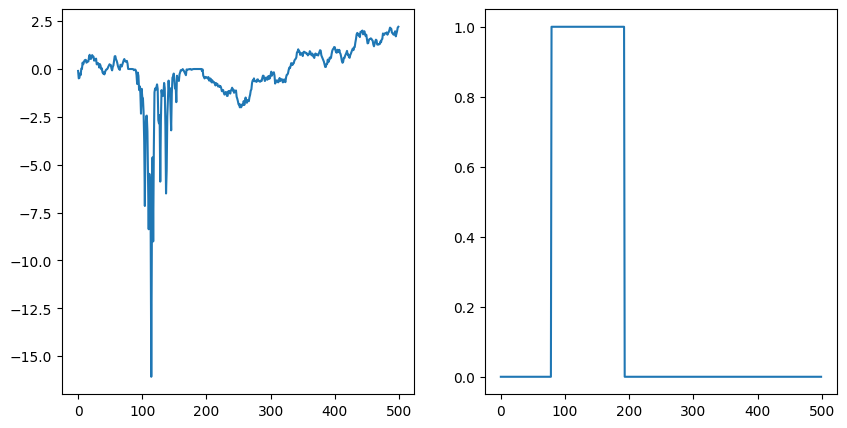

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# x, y = next(iter(DataLoader(train, batch_size=len(train))))

i = np.random.randint(0, len(dataset))
x, y = dataset[i]

ax1.plot(x)
ax2.plot(y)

In [8]:
dataset.save('../data/biconv_testing_dataset.pt')

In [9]:
dataset = read_epochs_dataset('../data/biconv_testing_dataset.pt')

In [10]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [59]:
class TimeSelNet(BaseModel):

    def __init__(
        self
    ):
        super().__init__()
        self.bc = AutoCov1D(
            out_channels=1,
            window_size=10,
            stride=10
        )
        self.bn = nn.BatchNorm1d(49)
        self.fc = nn.Linear(49, 500)
        self.activation = torch.nn.Sigmoid()


    def forward(self, x: torch.Tensor):
        x = torch.flatten(self.bc(x), 1)
        x = self.bn(x)
        x = self.fc(x)
        x = self.activation(x)
        return x

In [60]:
TimeSelNet()(next(iter(DataLoader(train, len(train))))[0])

tensor([[0.4975, 0.4731, 0.5224,  ..., 0.5326, 0.4888, 0.5027],
        [0.4955, 0.4742, 0.5230,  ..., 0.5317, 0.4885, 0.5012],
        [0.4977, 0.4736, 0.5223,  ..., 0.5322, 0.4890, 0.5028],
        ...,
        [0.4976, 0.4733, 0.5222,  ..., 0.5321, 0.4888, 0.5028],
        [0.4976, 0.4733, 0.5222,  ..., 0.5322, 0.4888, 0.5028],
        [0.4976, 0.4733, 0.5222,  ..., 0.5322, 0.4888, 0.5028]],
       grad_fn=<SigmoidBackward0>)

In [61]:
model = TimeSelNet()

optimizer = torch.optim.Adam
loss = torch.nn.L1Loss()
# loss = torch.nn.MSELoss()
# measure = ('mae', nn.L1Loss())

model.compile(
    optimizer,
    loss,
    # metrics=measure,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True, min_delta=0.001), # perform early stopping with restoring best weights
        # L2Reg(
        #     [
        #         'bc.weight',
        #     ], lambdas=.01
        # ) # l2 regularization for weights of spatial- and temporal filtering layers
    ],
)

Epoch 0:  loss_train:  0.4992   |    loss_val:  0.4987
Epoch 1:  loss_train:  0.4985   |    loss_val:  0.4983
Epoch 2:  loss_train:  0.4976   |    loss_val:  0.4978
Epoch 3:  loss_train:  0.4965   |    loss_val:  0.4973
Epoch 4:  loss_train:  0.4952   |    loss_val:  0.4968
Epoch 5:  loss_train:  0.4940   |    loss_val:  0.4962
Epoch 6:  loss_train:  0.4926   |    loss_val:  0.4956
Epoch 7:  loss_train:  0.4911   |    loss_val:  0.4950
Epoch 8:  loss_train:  0.4895   |    loss_val:  0.4942
Epoch 9:  loss_train:  0.4879   |    loss_val:  0.4933
Epoch 10: loss_train:  0.4861   |    loss_val:  0.4923
Epoch 11: loss_train:  0.4843   |    loss_val:  0.4912
Epoch 12: loss_train:  0.4825   |    loss_val:  0.4900
Epoch 13: loss_train:  0.4804   |    loss_val:  0.4887
Epoch 14: loss_train:  0.4783   |    loss_val:  0.4873
Epoch 15: loss_train:  0.4761   |    loss_val:  0.4858
Epoch 16: loss_train:  0.4737   |    loss_val:  0.4840
Epoch 17: loss_train:  0.4713   |    loss_val:  0.4818
Epoch 18: 

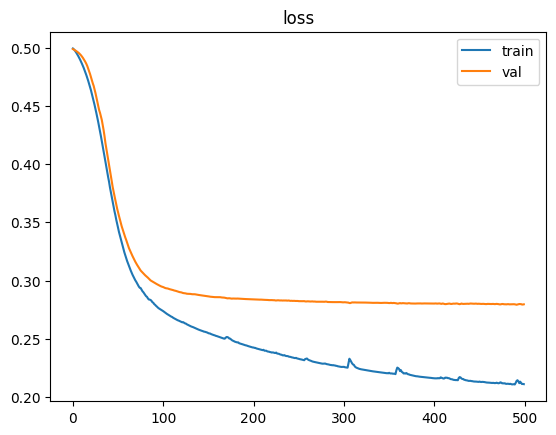

In [62]:
history = model.fit(train, n_epochs=500, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [63]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.29357313811779023
loss: 0.2723507985472679


In [46]:
x, y = next(iter(DataLoader(test, len(test))))
y_pred = model(x)

96


Text(0.5, 0.98, 'sample 269')

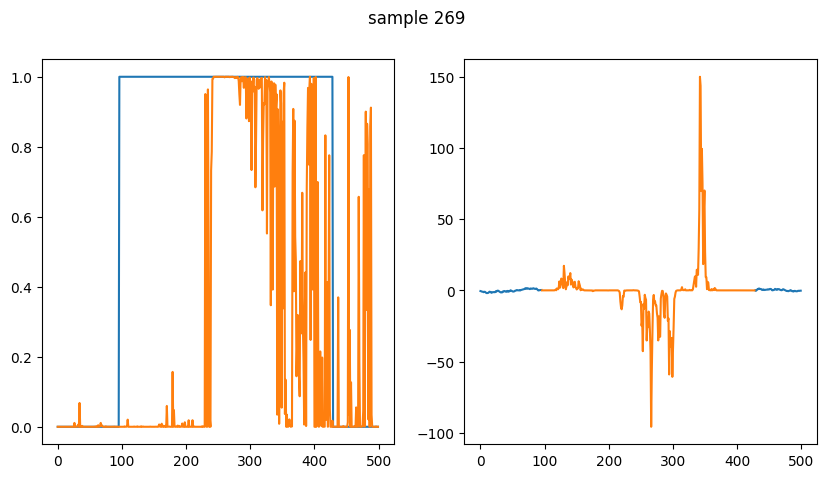

In [53]:
i = np.random.randint(300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

pred = y_pred.detach()[i]
sample_true = x[i].numpy()
true = np.where(y[i] == 1)[0]

sample_false = sample_true.copy()
sample_false[int(true[0]*len(sample_true)/len(pred)): int(true[-1]*len(sample_true)/len(pred))] = np.nan
sample_true[:int(true[0]*len(sample_true)/len(pred))] = np.nan
sample_true[int(true[-1]*len(sample_true)/len(pred)):] = np.nan


print(int(true[0]*len(x[i])/len(pred)))

ax1.plot(y[i])
ax1.plot((pred - pred.min())/(pred.max() - pred.min()))
ax2.plot(sample_false)
ax2.plot(sample_true)
fig.suptitle(f'sample {i}')
